In [2]:
%pip install xformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 23.4 MB/s  0:00:05 eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [30]:
%pip install matplotlib

  Using cached matplotlib-3.10.8-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.3.1-py3-none-any.whl.metadata (5.6 kB)
Using cached matplotlib-3.10.8-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
Using cached contourpy-1.3.3-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (362 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp313-cp313-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl (4.9 MB)
Using ca

In [56]:
import os
import torch
import itertools
import gc
import bitsandbytes as bnb
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig, get_peft_model
from torchvision import transforms
from PIL import Image
from accelerate import Accelerator

# --- CONFIGURATION ---
INSTANCE_PROMPT = "a photo of ohwx person" 
CLASS_DIR = "tiry_pics_processed" 
OUTPUT_DIR = "sd-tiry-lora-final"        
MODEL_NAME = "runwayml/stable-diffusion-v1-5"
RESOLUTION = 512

# 1. EXTENDED DURATION
TRAIN_STEPS = 3000       # 100 Epochs (Necessary for full UNet training)
LEARNING_RATE = 1e-4     
ACCUMULATION_STEPS = 4   

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
accelerator = Accelerator(
    mixed_precision="fp16",
    gradient_accumulation_steps=ACCUMULATION_STEPS 
)

# --- PHASE 1: PRE-PROCESSING ---
print("🏗️ PHASE 1: Encoding Images...")

tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(MODEL_NAME, subfolder="text_encoder").to(accelerator.device)
vae = AutoencoderKL.from_pretrained(MODEL_NAME, subfolder="vae").to(accelerator.device)

train_transforms = transforms.Compose([
    transforms.Resize(RESOLUTION, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

cached_data = []
image_files = [f for f in os.listdir(CLASS_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for filename in image_files:
    img = Image.open(os.path.join(CLASS_DIR, filename)).convert("RGB")
    pixel_values = train_transforms(img).unsqueeze(0).to(accelerator.device)
    
    with torch.no_grad():
        latents = vae.encode(pixel_values).latent_dist.sample() * vae.config.scaling_factor
        latents = latents.cpu()
        
    input_ids = tokenizer(
        INSTANCE_PROMPT, 
        padding="max_length", 
        truncation=True, 
        max_length=tokenizer.model_max_length, 
        return_tensors="pt"
    ).input_ids.to(accelerator.device)
    
    with torch.no_grad():
        encoder_hidden_states = text_encoder(input_ids)[0].cpu()
        
    cached_data.append({"latents": latents, "embeds": encoder_hidden_states})

del vae, text_encoder, tokenizer
torch.cuda.empty_cache()
gc.collect()

# --- PHASE 2: FINAL TRAINING ---
print("\n🚀 PHASE 2: Starting Max-Duration Training...")

unet = UNet2DConditionModel.from_pretrained(MODEL_NAME, subfolder="unet")
noise_scheduler = DDPMScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")

unet.requires_grad_(False)
unet.enable_gradient_checkpointing()
try:
    unet.enable_xformers_memory_efficient_attention()
except:
    pass

# TARGET MODULES
target_modules = [
    "to_k", "to_q", "to_v", "to_out.0", 
    "proj_in", "proj_out", 
    "ff.net.0.proj", "ff.net.2", 
    "time_emb_proj"
]

# 2. ALPHA = 128 (MASSIVE SIGNAL BOOST)
lora_config = LoraConfig(
    r=32,            
    lora_alpha=128,  # 4x Multiplier relative to Rank. Forces weights to matter.
    target_modules=target_modules,
    init_lora_weights="gaussian",
)
unet = get_peft_model(unet, lora_config)
optimizer = bnb.optim.AdamW8bit(unet.parameters(), lr=LEARNING_RATE)
unet, optimizer = accelerator.prepare(unet, optimizer)

unet.train()
data_iter = itertools.cycle(cached_data)

print(f"   Training for {TRAIN_STEPS} steps...")

for step in range(TRAIN_STEPS):
    item = next(data_iter)
    latents = item["latents"].to(accelerator.device, dtype=torch.float16)
    embeds = item["embeds"].to(accelerator.device, dtype=torch.float16)
    
    noise = torch.randn_like(latents)
    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()
    noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
    
    model_pred = unet(noisy_latents, timesteps, embeds).sample
    
    loss = torch.nn.functional.mse_loss(model_pred.float(), noise.float(), reduction="mean")
    loss = loss / ACCUMULATION_STEPS
    accelerator.backward(loss)
    
    if (step + 1) % ACCUMULATION_STEPS == 0:
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
    
    if step % 500 == 0:
        print(f"   Step {step}/{TRAIN_STEPS} | Loss: {loss.item() * ACCUMULATION_STEPS:.4f}")

print("\n✅ Training Complete!")
unet.save_pretrained(OUTPUT_DIR)

🏗️ PHASE 1: Encoding Images...

🚀 PHASE 2: Starting Max-Duration Training...
   Training for 3000 steps...
   Step 0/3000 | Loss: 0.0660
   Step 500/3000 | Loss: 0.0172
   Step 1000/3000 | Loss: 0.0036
   Step 1500/3000 | Loss: 0.1303
   Step 2000/3000 | Loss: 0.0093
   Step 2500/3000 | Loss: 0.1476

✅ Training Complete!


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

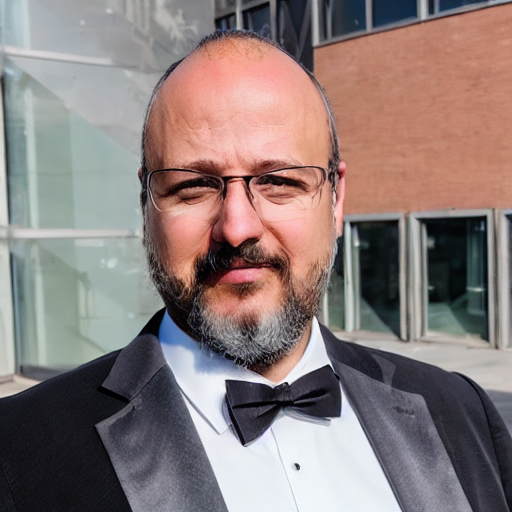

In [58]:
import torch
from diffusers import StableDiffusionPipeline
from peft import PeftModel

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, safety_checker=None).to("cuda")
pipe.unet = PeftModel.from_pretrained(pipe.unet, "sd-tiry-lora-final") # Load v2
pipe.unet.to("cuda")

# TRIGGER: "ohwx person"
prompt = "A professional headshot of ohwx person in a suit, 8k, sharp focus, cinematic lighting, detailed eyes"
image = pipe(prompt, negative_prompt="blur, low quality, distortion, ugly", num_inference_steps=50).images[0]
display(image)

Loading Base Model...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading LoRA from sd-tiry-lora-final...

Generating Test Grid...
   Generating Scale 0.8...


  0%|          | 0/50 [00:00<?, ?it/s]

   Generating Scale 0.9...


  0%|          | 0/50 [00:00<?, ?it/s]

   Generating Scale 1.0...


  0%|          | 0/50 [00:00<?, ?it/s]

   Generating Scale 1.1...


  0%|          | 0/50 [00:00<?, ?it/s]

   Generating Scale 1.2...


  0%|          | 0/50 [00:00<?, ?it/s]

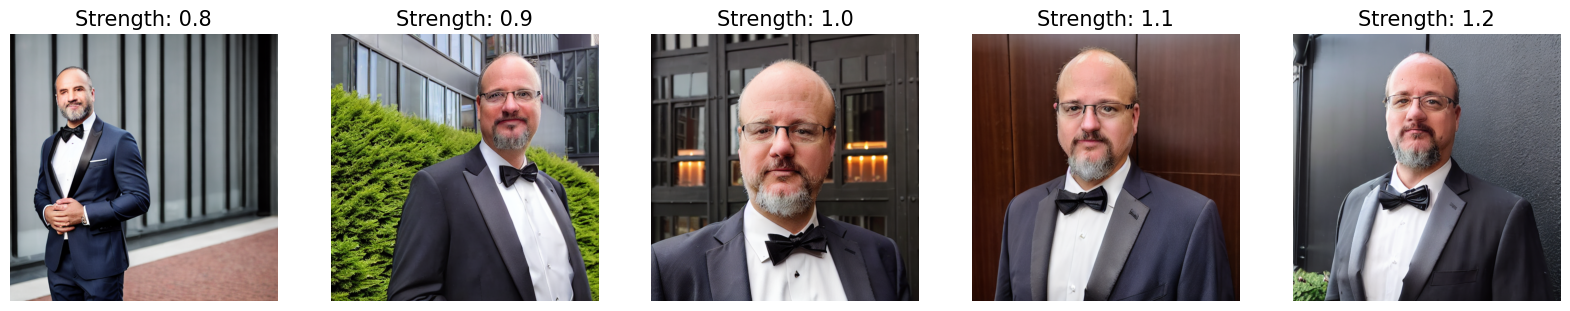

In [61]:
import torch
from diffusers import StableDiffusionPipeline
from peft import PeftModel
import matplotlib.pyplot as plt

# 1. Load Base
print("Loading Base Model...")
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

# 2. Load Your Precision LoRA
LORA_DIR = "sd-tiry-lora-final"
print(f"Loading LoRA from {LORA_DIR}...")
pipe.unet = PeftModel.from_pretrained(pipe.unet, LORA_DIR)
pipe.unet.to("cuda")

# 3. Setup The Test
prompt = "A professional headshot of ohwx person in a suit, 8k, sharp focus, cinematic lighting"
negative_prompt = "cartoon, drawing, anime, blur, low quality, distortion, ugly, deformed"
scales = [0.8, 0.9, 1.0, 1.1, 1.2] # Testing stronger weights

print("\nGenerating Test Grid...")
images = []
titles = []

for scale in scales:
    print(f"   Generating Scale {scale}...")
    image = pipe(
        prompt=prompt, 
        negative_prompt=negative_prompt, 
        num_inference_steps=50,
        guidance_scale=7.5,
        cross_attention_kwargs={"scale": scale} # The Magic Lever
    ).images[0]
    
    images.append(image)
    titles.append(f"Strength: {scale}")

# 4. Display Side-by-Side
fig, axs = plt.subplots(1, 5, figsize=(20, 6))
for i, (img, title) in enumerate(zip(images, titles)):
    axs[i].imshow(img)
    axs[i].set_title(title, fontsize=15)
    axs[i].axis("off")
plt.show()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Generating Showcase...
   Generating: A professional headshot of ohw...


  0%|          | 0/50 [00:00<?, ?it/s]

   Generating: A candid photo of ohwx person ...


  0%|          | 0/50 [00:00<?, ?it/s]

   Generating: Oil painting of ohwx person as...


  0%|          | 0/50 [00:00<?, ?it/s]

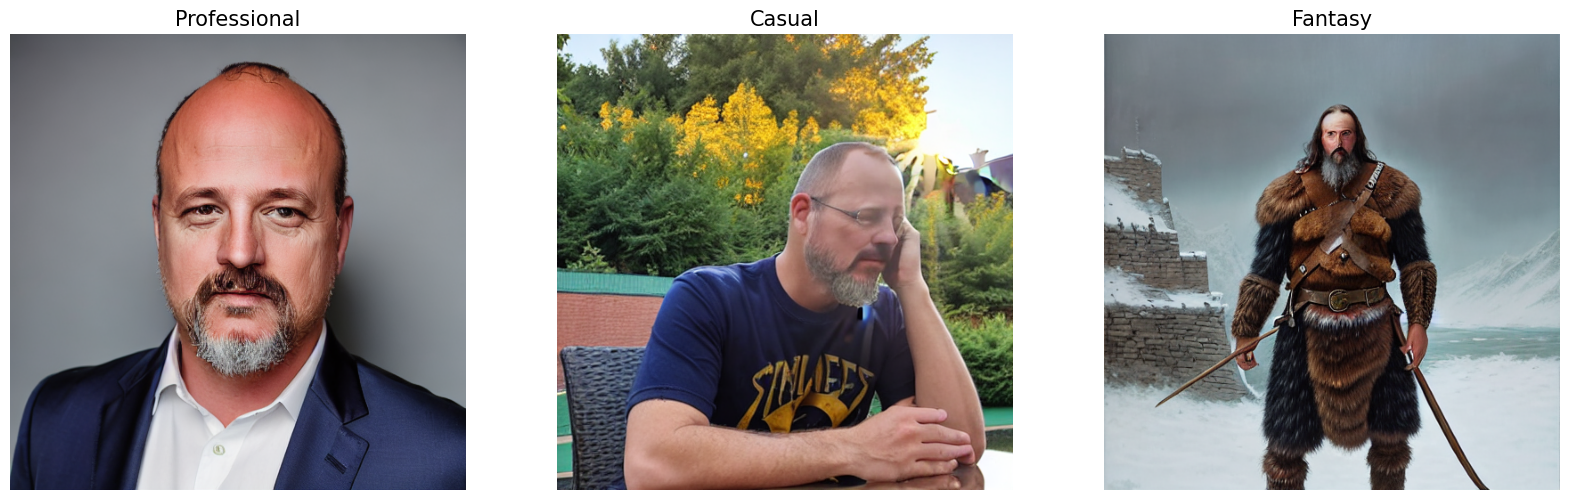

In [60]:
import torch
from diffusers import StableDiffusionPipeline
from peft import PeftModel
import matplotlib.pyplot as plt

# 1. Load Base
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    torch_dtype=torch.float16, 
    safety_checker=None
).to("cuda")

# 2. Load the Final LoRA
LORA_DIR = "sd-tiry-lora-final"
pipe.unet = PeftModel.from_pretrained(pipe.unet, LORA_DIR)
pipe.unet.to("cuda")

# 3. The Three Styles
prompts = [
    # 1. Professional (The "LinkedIn" test)
    "A professional headshot of ohwx person in a navy blue suit, white shirt, studio lighting, 8k, sharp focus, canon 5d",
    
    # 2. Casual (The "Reality" test)
    "A candid photo of ohwx person wearing a t-shirt at a coffee shop, golden hour lighting, depth of field, bokeh",
    
    # 3. Fantasy (The "Stylization" test)
    "Oil painting of ohwx person as a viking warrior, fur armor, snow storm background, intricate beard detail, artstation, greg rutkowski"
]

negative_prompt = "cartoon, drawing, anime, blur, low quality, distortion, ugly, deformed, extra fingers"

print("Generating Showcase...")
images = []
for p in prompts:
    print(f"   Generating: {p[:30]}...")
    # Scale 1.0 should work now. If slightly too strong, try 0.9.
    img = pipe(p, negative_prompt=negative_prompt, num_inference_steps=50, cross_attention_kwargs={"scale": 1.0}).images[0]
    images.append(img)

# 4. Display
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
titles = ["Professional", "Casual", "Fantasy"]
for i, (img, title) in enumerate(zip(images, titles)):
    axs[i].imshow(img)
    axs[i].set_title(title, fontsize=15)
    axs[i].axis("off")
plt.show()